# Comparisons of differences in brain regions

This notebook performs exploratory analyses for the mouse connectomes. For each mouse, we have a matrix consisting of the average volume and fractional antisotropy in a given region. These data matrices are first normalized across mice. Using the normalized measurements, compute the pairwise differences between all pairs of regions to form distance matrices, whose entries indicate the difference in the indicated measurement type (volume; mean FA) between a given pair of regions. 

In [1]:
import graspologic as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from pkg.data import (
    GENOTYPES,
    HEMISPHERES,
    SUB_STRUCTURES,
    SUPER_STRUCTURES,
    load_fa,
    load_fa_corr,
    load_vertex_df,
    load_vertex_metadata,
    load_volume,
    load_volume_corr,
)
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multitest import multipletests

import hyppo
from hyppo.ksample import MANOVA, KSample

In [11]:
volumes = pd.read_csv("../data/processed/volumes.csv")
fa = pd.read_csv("../data/processed/fa.csv")
meta = pd.read_csv("../data/processed/meta.csv")

labels = meta.Genotype.values
unique_labels = ["ApoE 2", "ApoE 3", "ApoE 4"]

vols = []
for idx, row in meta.iterrows():
    ID = row["ID"]
    vols.append(volumes[[ID]].values.ravel())

fas = []
for idx, row in meta.iterrows():
    ID = row["ID"]
    fas.append(fa[[ID]].values.ravel())

vols = np.vstack(vols)
vols /= vols.sum(axis=1, keepdims=True)

fas = np.vstack(fas)
fas /= fas.sum(axis=1, keepdims=True)

vol_dists = np.array([squareform(pdist(v.reshape(-1, 1))) for v in vols])
fa_dists = np.array([squareform(pdist(v.reshape(-1, 1))) for v in fas])

## Visualize the average differences between regions and the abolute differences in genotypes

We first visualize the mean distance matrix separated by genotypes. We do not observe specific patterns among the genotypes, but we see that very few select regions have significantly high differences in brain regions. Here take the absolute differences in the mean distance matrices, and visualize the resulting matrix. We now see that different pairs of genotypes show distinct patterns.

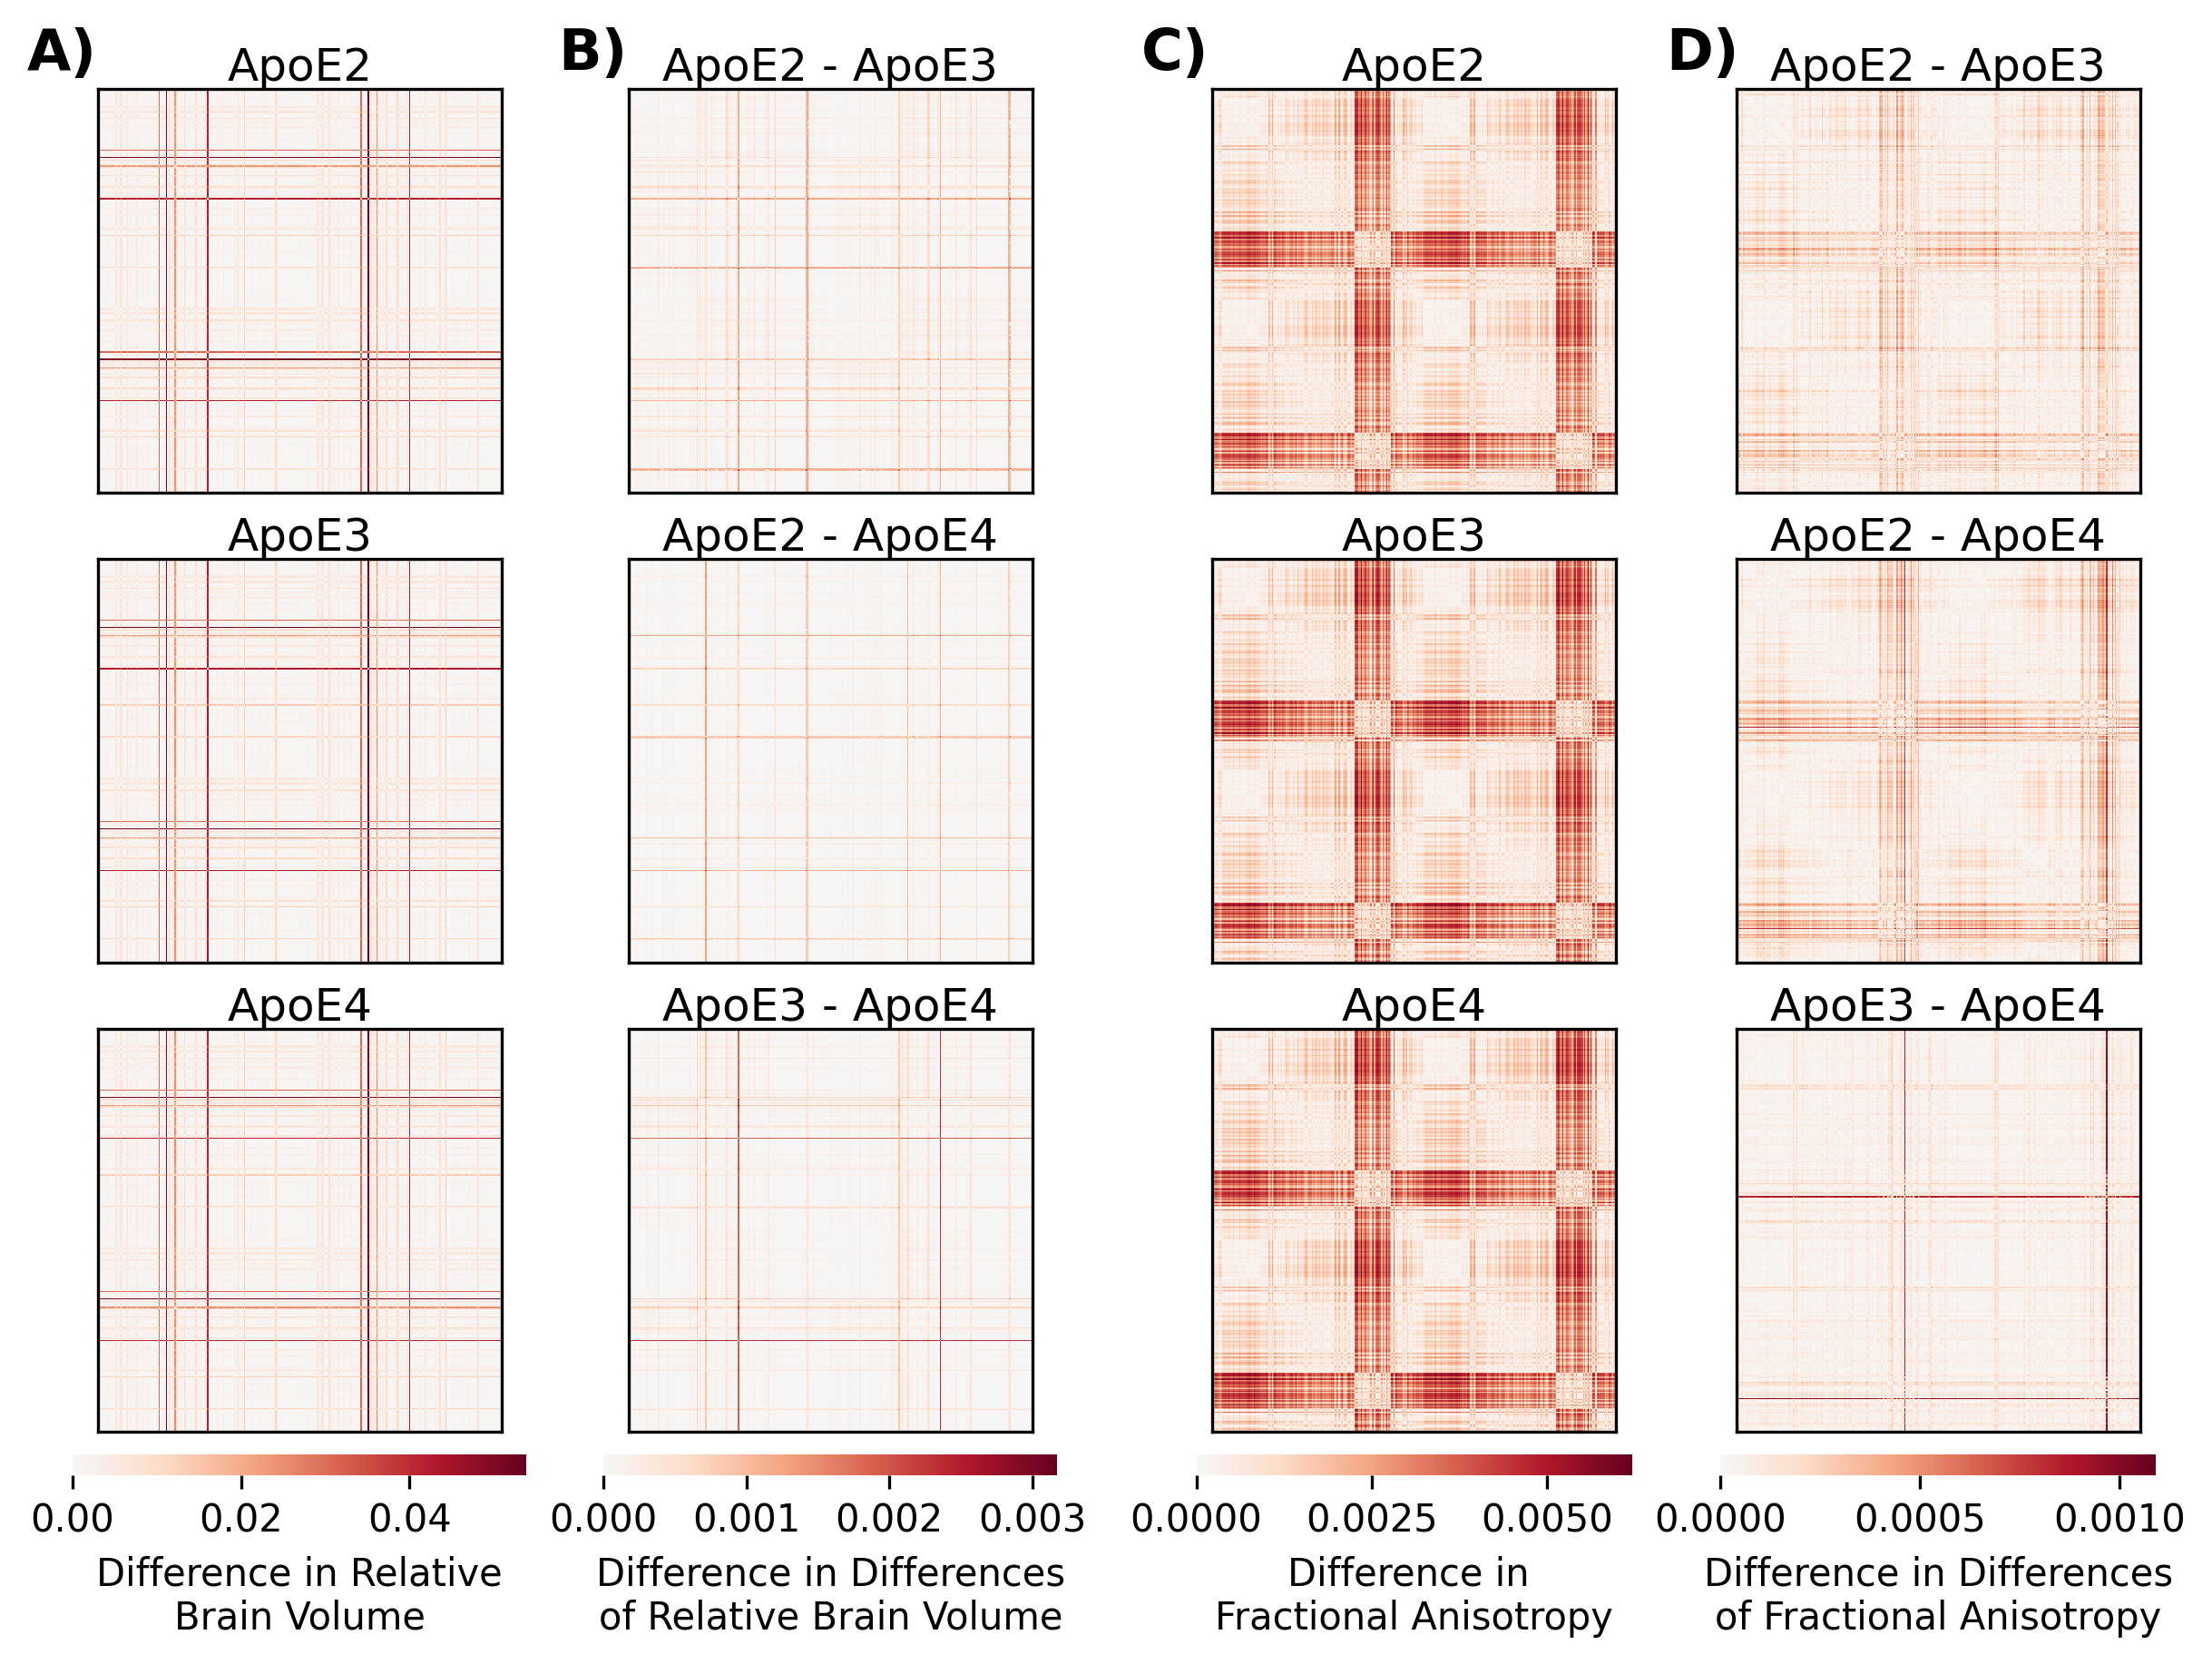

In [41]:
fig = plt.figure(layout="constrained", figsize=(8, 6), dpi=300)
subfigs = fig.subfigures(1, 2)

axsLeft = subfigs[0].subplots(
    ncols=2,
    nrows=4,
    gridspec_kw=dict(height_ratios=[1, 1, 1, 0.05]),
)

axsRight = subfigs[1].subplots(
    ncols=2,
    nrows=4,
    gridspec_kw=dict(height_ratios=[1, 1, 1, 0.05]),
)

means = [vol_dists[labels == label].mean(axis=0) for label in np.unique(labels)]

vmin = np.min(means)
vmax = np.max(means)

ax = axsLeft.T

for idx, label in enumerate(np.unique(labels)):
    sns.heatmap(
        means[idx],
        ax=ax[0, idx],
        vmin=vmin,
        vmax=vmax,
        cbar_ax=ax[0, -1],
        cbar=True,
        cmap="RdBu_r",
        center=0,
        xticklabels=[],
        yticklabels=[],
        cbar_kws={"orientation": "horizontal"},
        square=True,
    )
    ax[0, idx].set_title(f"{unique_labels[idx]}", pad=0, size=12)
    sns.despine(
        ax=ax[0, idx],
        top=False,
        right=False,
        left=False,
        bottom=False,
        offset=None,
        trim=False,
    )

ax[0, -1].set_xlabel("Difference in Relative\nBrain Volume")


datas = [
    np.abs(means[label1] - means[label2]) for label1, label2 in [(0, 1), (0, 2), (1, 2)]
]
vmin = np.min(datas)
vmax = np.max(datas)

for idx, (label1, label2) in enumerate([(0, 1), (0, 2), (1, 2)]):
    sns.heatmap(
        datas[idx],
        ax=ax[1, idx],
        vmin=vmin,
        vmax=vmax,
        cbar_ax=ax[1, -1],
        cbar=True,
        cmap="RdBu_r",
        center=0,
        xticklabels=[],
        yticklabels=[],
        cbar_kws={"orientation": "horizontal"},
        square=True,
    )
    sns.despine(
        ax=ax[1, idx],
        top=False,
        right=False,
        left=False,
        bottom=False,
        offset=None,
        trim=False,
    )

    ax[1, idx].set_title(
        f"{unique_labels[label1]} - {unique_labels[label2]}", pad=0, size=12
    )
    ax[1, -1].set_xlabel("Difference in Differences\nof Relative Brain Volume")

ax[0, 0].text(
    -0.175,
    1.02,
    "A)",
    ha="left",
    va="bottom",
    transform=ax[0, 0].transAxes,
    # fontdict={"family": "monospace"},
    fontsize=15,
    weight="bold",
)

ax[1, 0].text(
    -0.175,
    1.02,
    "B)",
    ha="left",
    va="bottom",
    transform=ax[1, 0].transAxes,
    # fontdict={"family": "monospace"},
    fontsize=15,
    weight="bold",
)


# fig.savefig("../results/figures/fig1.png", bbox_inches="tight", dpi=300)
# fig.savefig("../results/figures/fig1.svg", bbox_inches="tight", dpi=300)

means = [fa_dists[labels == label].mean(axis=0) for label in np.unique(labels)]

vmin = np.min(means)
vmax = np.max(means)

ax = axsRight.T


for idx, label in enumerate(np.unique(labels)):
    sns.heatmap(
        means[idx],
        ax=ax[0, idx],
        vmin=vmin,
        vmax=vmax,
        cbar_ax=ax[0, -1],
        cbar=True,
        cmap="RdBu_r",
        center=0,
        xticklabels=[],
        yticklabels=[],
        cbar_kws={"orientation": "horizontal"},
        square=True,
    )
    ax[0, idx].set_title(f"{unique_labels[idx]}", pad=0, size=12)
    sns.despine(
        ax=ax[0, idx],
        top=False,
        right=False,
        left=False,
        bottom=False,
        offset=None,
        trim=False,
    )

ax[0, -1].set_xlabel("Difference in \nFractional Anisotropy")


datas = [
    np.abs(means[label1] - means[label2]) for label1, label2 in [(0, 1), (0, 2), (1, 2)]
]
vmin = np.min(datas)
vmax = np.max(datas)

for idx, (label1, label2) in enumerate([(0, 1), (0, 2), (1, 2)]):
    sns.heatmap(
        datas[idx],
        ax=ax[1, idx],
        vmin=vmin,
        vmax=vmax,
        cbar_ax=ax[1, -1],
        cbar=True,
        cmap="RdBu_r",
        center=0,
        xticklabels=[],
        yticklabels=[],
        cbar_kws={"orientation": "horizontal"},
        square=True,
    )
    sns.despine(
        ax=ax[1, idx],
        top=False,
        right=False,
        left=False,
        bottom=False,
        offset=None,
        trim=False,
    )

    ax[1, idx].set_title(
        f"{unique_labels[label1]} - {unique_labels[label2]}", pad=0, size=12
    )
    ax[1, -1].set_xlabel("Difference in Differences\nof Fractional Anisotropy")


ax[0, 0].text(
    -0.175,
    1.02,
    "C)",
    ha="left",
    va="bottom",
    transform=ax[0, 0].transAxes,
    # fontdict={"family": "monospace"},
    fontsize=15,
    weight="bold",
)

ax[1, 0].text(
    -0.175,
    1.02,
    "D)",
    ha="left",
    va="bottom",
    transform=ax[1, 0].transAxes,
    # fontdict={"family": "monospace"},
    fontsize=15,
    weight="bold",
)

fig.savefig("../figures/figure_2.png", dpi=300, bbox_inches="tight")